# Проектная работа по дисциплине "Теория обнаружения вторжений с применением искусственного интеллекта"

#### Тема проекта: "Обнаружение фишинговых сообщений с помощью нейронных сетей"
#### Команда, работающая над проектом, представлена группой студентов:
- **ББМО-02-22 Кузьмин Владимир Дмитриевич**
- ББМО-02-22 Исаев Александр Михайлович
- ББМО-01-22 Загороднов Егор Алексеевич
- ББМО-01-22 Карев Даниил Павлович

# Актуальность
В 2022 году количество фишинговых атак заметно выросло. Система «Антифишинг» пресекла 507 851 735 попыток перехода по фишинговым ссылкам – это примерно вдвое больше, чем в 2021-м.

В последнее время мы наблюдаем увеличение количества целевых фишинговых атак, при которых мошенники переходят к самой фишинговой атаке не сразу, а после нескольких «ознакомительных» писем, в которых активно переписываются с жертвой. Скорее всего, эта тенденция продолжится. Также вероятно появление в 2023 году новых уловок в корпоративном секторе, атаки на который приносят злоумышленникам значительную прибыль [1].

С января по апрель 2022 года защитные решения "Лаборатории Касперского" заблокировали более 800 тысяч фишинговых писем на русском языке с вредоносными HTML-вложениями, почти половину из них – в марте. Такой метод представляет собой продвинутый с технической точки зрения и распространенный прием для выманивания данных пользователей, в том числе платежных [2].

Аналитики Positive Technologies подтверждают: социальная инженерия в тренде у злоумышленников. В III квартале 2022 года число массовых кампаний с использованием социальной инженерии увеличилось на 41% в атаках на организации и на 34% в атаках на частных лиц по сравнению с результатами II квартала. Преимущественно такой рост вызван активным использованием фишинговых комплектов – готовых наборов программ, предназначенных для проведения фишинговой атаки [3].

# Объект и предмет исследования
Объектом исследования данной работы является классификация фишинговых сообщений. Предметом исследования является создание и обучение нейронной сети для классификации фишинговых сообщений.

# Методы исследования
В ходе работы над проектом будут использованы такие методы исследования, как эмпирические, так и теоретические.

# Цель и задачи
Таким образом, цель данной работы – обнаружение фишинговых сообщений с помощью нейронных сетей.
Для достижения поставленной цели необходимо выполнить следующие задачи:

1. Подготовить данные для обучения;
1. Предобработать данные;
1. Подготовить наборы для обучения и тестирования;
1. Произвести обучение;
1. Обработать данные результатов обучения;
1. Протестировать обученную модель;
1. Повторить предыдущие этапы для различных моделей;
1. Выбрать наилучшую модель для достижения цели работы.

# Основная часть
## Фишинг
Фишинг – это вид интернет-мошенничества, при котором злоумышленник создает ложную 
страницу в интернете, имитирующую настоящий сайт, с целью получить доступ к личным 
данным пользователя или его финансовым средствам.

Часто фишинговые сайты маскируются под популярные банки, онлайн-магазины, 
социальные сети и другие популярные интернет-ресурсы. Пользователь, переходя на 
такой сайт, вводит свои логин и пароль, а злоумышленник получает доступ к этой 
информации.

Существует несколько способов, которые могут помочь обнаружить фишинг:
Проверка URL-адреса: Перед вводом личных данных на страницу, пользователь должен 
проверить URL-адрес и убедиться, что он соответствует настоящему сайту. Если адрес 
начинается с "http" вместо "https", это может свидетельствовать о том, что сайт не 
защищен.

Проверка сертификата безопасности: Настоящий сайт обычно имеет сертификат 
безопасности. Пользователь может проверить его наличие, кликнув на замочек в 
адресной строке браузера.

Бережность при получении электронных писем: Фишинг-атаки могут приходить в виде 
электронных писем, которые выглядят, как будто они отправлены от реального 
отправителя. Пользователь должен быть бдительным при получении подобных писем и 
не переходить на вложенные ссылки.

Использование антивирусного программного обеспечения: Антивирусное ПО может 
помочь обнаружить фишинг-сайты и предупредить пользователя о потенциальной угрозе.
Бережность при вводе личных данных: Пользователь должен быть бдительным при 
вводе личных данных, особенно на незнакомых сайтах. Если что-то кажется 
подозрительным, лучше отказаться от ввода информации.

Обновление программного обеспечения: Часто фишинг-атаки используют уязвимости в 
программном обеспечении, чтобы получить доступ к личным данным. Пользователь 
должен регулярно обновлять программное обеспечение на своем компьютере и 
мобильном устройстве, чтобы защититься от таких уязвимостей.

## Как определить фишинговое письмо
Ниже перечислены некоторые признаки, которые могут указывать на то, что вы получили фишинговое письмо:

- **Отправитель**: Фишинговое письмо может быть отправлено от адреса электронной почты, который похож на адрес реального отправителя, но имеет некоторые отличия. Например, вместо "example.com" может быть "examp1e.com" или "exampIe.com", где буквы "l" и "I" заменены цифрами. Также злоумышленники могут использовать адреса электронной почты, которые выглядят знакомыми, но на самом деле не имеют никакого отношения к доверенному отправителю.

- **Содержание**: Фишинговое письмо может содержать странные или неожиданные запросы, например, просьбу изменить пароль или предоставить финансовую информацию. Также могут быть ошибки в грамматике или орфографии, что указывает на то, что письмо не прошло проверку правописания.

- **Ссылки**: Фишинговое письмо может содержать ссылки на поддельные веб-сайты, которые выглядят как официальные сайты, но на самом деле используются для сбора личной информации. Если вы наведете курсор мыши на ссылку, то увидите, что она ведет на другой адрес, отличный от адреса, который был указан в письме.

- **Вложения**: Фишинговое письмо может содержать вложения, которые выглядят как документы или файлы, но на самом деле могут содержать вредоносное ПО или вирусы. Если вы не уверены в подлинности вложения, не открывайте его и не скачивайте на свой компьютер.

**Вот пример содержания фишингового письма**:

>Уважаемый клиент,
>
>Мы заметили необычную активность на вашем банковском счете и просим вас обновить свои данные, чтобы предотвратить возможные мошеннические операции. Пожалуйста, пройдите по ссылке ниже и введите свой логин и пароль, чтобы обновить свою учетную запись.
>
>https://www.mybankingwebsite.com/login
>
>С уважением,
>
>Отдел безопасности банка

Это типичный пример фишингового письма, в котором злоумышленник пытается обмануть получателя, выдавая себя за доверенную организацию. Он содержит ссылку на поддельный сайт, который выглядит как официальный сайт банка, и просит вас ввести свои учетные данные. Если вы введете свой логин и пароль на этом сайте, то злоумышленник получит доступ к вашим личным данным и сможет использовать их для мошенничества.

**Вот пример фишинговой ссылки**:

>https://www.paypal.com.updateaccount.com

На первый взгляд, это может выглядеть как настоящая ссылка на сайт PayPal. Однако, если внимательно посмотреть на ссылку, то можно заметить, что она содержит дополнительный поддомен "updateaccount.com", который не является официальным доменом PayPal. Это может быть признаком того, что это фишинговая ссылка, которую используют злоумышленники, чтобы обмануть пользователей и получить их личную информацию. Если вы введете свои данные на таком сайте, то злоумышленники могут получить доступ к вашим личным данным и использовать их для мошеннических целей. Поэтому, важно быть осторожным при открытии ссылок в письмах и проверять их на подлинность, особенно если они запрашивают личную информацию.

**Фишинговые вложения**:

Предположим, вы получили письмо с вложением, которое якобы содержит важную информацию от вашего банка или другой доверенной организации. Но после того, как вы скачиваете и открываете вложение, вы обнаруживаете, что это файл с расширением .exe или .zip. Это может быть зловредным ПО (вирусом), которое пытается заразить ваш компьютер, чтобы получить доступ к вашей личной информации.

Например, вложение может иметь название "Important_Bank_Documents.exe" или "Important_Update.zip". Если вы запустите такой файл, то ваш компьютер может быть заражен вирусом, который будет собирать ваши личные данные и отправлять их злоумышленникам.

Поэтому, важно быть осторожным при открытии вложений в письмах, особенно если они приходят от незнакомых отправителей или запрашивают ввод пароля или другой личной информации. Не открывайте вложения, если вы не уверены в их подлинности, а также используйте антивирусное ПО для защиты вашего компьютера от вредоносных программ.

Вредоносным файлом может оказаться любое вложение. Ярким примером является реализация хищения данных с компьютера жертвы через вложение в формате .doc в фишинговом письме, где злоумышленникам потребовалось всего лишь **15 минут** на реализацию атаки [3].

## Подытоживая
Для определения фишингового сообщения следует обращать внимание на орфографию, лишние символы в тексте, вложения, ссылки. Попробуем использовать эти данные для обучения и тестирования модели машинного обучения.

## Обнаружение фишинговых сообщений
#### Для обучения и тестирования модели будут использованы следующие датасеты:
- Nazario (фишинговые сообщения);
- Enron (легитимные сообщения).
#### Признаки, на основе которых будет происходить обучение моделей:
- длина почты отправителя;
- количество точек в почте отправителя;
- количество тире в почте отправителя;
- количество специальных символов в почте отправителя;
- количество цифр в почте отправителя;
- количество поддоменов в почте отправителя;
- количество ссылок;
- количество точек в ссылках;
- количество тире в ссылках;
- количество специальных символов в ссылках;
- наличие IP-адреса в ссылках;
- количество IP-адресов в ссылках;
- количество https ссылок;
- количество вложений;
- класс;
- количество часто встречаемых слов в фишинговых сообщениях.

## Библиотеки
Импортируем необходимые библиотеки для предобработки данных

In [1]:
#при необходимости установить недостающие библиотеки
#%pip install keras
#%pip install tensorflow

In [2]:
import re
import os
import nltk
import string
import mailbox
import pandas as pd
import numpy as np
import keras
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from email.header import decode_header
from nltk.tokenize import word_tokenize
from sklearn import model_selection
#модуль для разбиения датасета на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
#модель случайные леса
from sklearn.ensemble import RandomForestClassifier
#модель адабуст
from sklearn.ensemble import AdaBoostClassifier
#модель к-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
#модель бэггинга
from sklearn.ensemble import BaggingClassifier
#модель ExtraTrees
from sklearn.ensemble import ExtraTreesClassifier
#модель дерева решений
from sklearn.tree import DecisionTreeClassifier
#модель логистической регрессии
from sklearn.linear_model import LogisticRegression
#модель опорных векторов
from sklearn.svm import SVC
#модель наивного байеса
from sklearn.naive_bayes import MultinomialNB
#многослойный персептрон
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
#метрики для моделей
from sklearn.metrics import accuracy_score, precision_score
#модуль голосования классификаторов
from sklearn.ensemble import VotingClassifier
#библиотека визуализации
import matplotlib.pyplot as plt
#библиотека для сохранения и загрузки моделей
import joblib

## Предобработка
Предобработаем текст для дальнейшего обучения

Получаем датасеты с легитимными и фишинговыми письмами

In [3]:
phishing_emails = mailbox.mbox('./Datasets/nazario-phishing.mbox')
valid_emails = mailbox.mbox('./Datasets/enron-legal.mbox')

In [4]:
#загрузим стоп-слова
#nltk.download('stopwords') 
#загрузим символы пунктуации
#nltk.download('punkt')

Объявим класс, в котором будем парсить письма, разбивая их на части

In [5]:
class EmailParser:
    #зададим регулярные выражения для определения ссылок и адресов почты
    urlRegex = r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=;]*)'
    emailRegex = r'([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)'
    
    #конструктор класса
    def __init__(self, email):
        #получаем на вход письмо
        self.email = email
        #запускаем функцию разбиения письма на части
        self.__extract_email_parts()
    
    #функция разбиения письма на части
    def __extract_email_parts(self):
        #количество вложений
        no_of_attachments = 0
        #текст сообщения
        text = str(self.email['Subject']) + " "
        #html код сообщения
        htmlDoc = ""
        #проходимся по частям письма
        for part in self.email.walk():
            #определяем тип содержимого
            content_type = part.get_content_type()
            #если сообщение представлено обычным текстом
            if content_type == 'text/plain':
                #записываем в текст
                text += str(part.get_payload())
            #если сообщение представлено html кодом
            elif content_type == 'text/html':
                #записываем в html
                htmlDoc += part.get_payload()
            #в остальных случаях
            else:
                #смотрим основной тип содержимого
                main_content_type = part.get_content_maintype()
                #если представлен изображением или приложением
                if main_content_type in ['image','application']:
                    #считаем как вложение
                    no_of_attachments += 1
        #передаем полученные значения в переменные класса
        self.text, self.html, self.no_of_attachments = text, htmlDoc, no_of_attachments
    
    #ищем ссылки
    def get_urls(self):
        #регулярным выражением выуживаем ссылки из текст сообщения
        text_urls = set(re.findall(EmailParser.urlRegex,self.text))
        #и из html-кода
        html_urls = set(re.findall(EmailParser.urlRegex,self.html))
        #возвращаем результат в виде списка найденных ссылок
        return list(text_urls.union(html_urls))
    
    #получаем текст сообщения
    def get_email_text(self):
        #если письмо несет в себе тип html-кода
        if(self.html != ""):
            #парсим код классом BeautifulSoup
            soup = BeautifulSoup(self.html)
            #выуживаем текст из кода
            self.text += soup.text
        #возвращаем результат собранного текста
        return self.text
    
    #функция, возвращающая количество вложений
    def get_no_of_attachments(self):
        return self.no_of_attachments
    
    #получаем почту отправителя
    def get_sender_email_address(self):
        sender = email['From']
        try:
            #пытаемся регулярным выражением выудить почту отправителя
            emails = re.findall(EmailParser.emailRegex, sender)
        except:
            #если регуляркой не вышло, пробуем через байтовое представление
            h = decode_header(email['From'])
            header_bytes = h[0][0]
            sender = header_bytes.decode('ISO-8859-1')
            emails = re.findall(EmailParser.emailRegex, sender)
        #возвращаем результат
        if(len(emails) != 0):
            return emails[len(emails)-1]
        else:
            return ''

Объявим класс, в котором будем обрабатывать текст сообщения

In [6]:
class StringUtil:
    #объявим регулярные выражения для выуживания
    #точек
    dotRegex = r'\.'
    #цифр
    digitsRegex = r'[0-9]'
    #ip-адресов
    ipAddressRegex = r'(?:[0-9]{1,3}\.){3}[0-9]{1,3}'
    #тире
    dashesRegex = r'-'
    #специальных символов
    specialCharsRegex = r'[()@:%_\+~#?\=;]'
    
    #объявим счетчик слов
    words = Counter()
    #зафиксируем стоп-слова для английского языка
    stop_words = set(stopwords.words('english'))
    #инициализируем класс Портера Стеммера
    stemmer = nltk.PorterStemmer()
    
    #объявим функцию обработки ссылок
    def process_urls(self,urls):
        #объявим переменные, которые будут нашими признаками
        noOfDots, noOfDashes, noOfSpecialChars, hasIpAddressInUrl, noOfIpAddress, noOfHttpLinks = 0,0,0,0,0,0
        #обрабатываем все ссылки
        for url in urls:
            #если ссылка начинается с http://
            if url.startswith('http://'):
                #считаем http
                noOfHttpLinks += 1
            #считаем количетсво точек
            noOfDots += len(re.findall(StringUtil.dotRegex,url))
            #считаем количество тире
            noOfDashes += len(re.findall(StringUtil.dashesRegex,url))
            #считаем количество специальных символов
            noOfSpecialChars += len(re.findall(StringUtil.specialCharsRegex,url))
            #считаем количество ip-адресов
            noOfIpAddress += len(re.findall(StringUtil.ipAddressRegex, url))
        #если ip-адреса были найдены
        if noOfIpAddress > 0:
            #фиксируем наличие ip-адресов в ссылках
            hasIpAddressInUrl = 1
        #возвращаем собранные признаки
        return len(urls), noOfDots, noOfDashes, noOfSpecialChars, hasIpAddressInUrl, noOfIpAddress, noOfHttpLinks
    
    #объявим функцию обработки текста
    def process_text(self, text):
        #приведем текст в нижнему регистру
        text = text.lower()
        #удалим из текста символы переноса курсора
        text = re.sub(r'[\n\t\r]', ' ', text)
        
        #удаляем пунктуацию
        punctuation = string.punctuation  #получаем все символы пунктуации
        translator = str.maketrans('', '', punctuation + string.digits)  #создаем транслятор
        text = text.translate(translator)  #удаляем пунктуацию и цифры транслятором

        #выделим токены из текста
        word_tokens = word_tokenize(text)
        filtered_text = []
        for w in word_tokens:
            #исключим стоп-слова
            if w not in StringUtil.stop_words:
                filtered_text.append(w)
        
        #счетчик частоты слов
        word_counts = Counter(filtered_text)
        stemmed_word_count = Counter()
        for word, count in word_counts.items():
            #обрабатываем каждое слово алгоритмом стемминга
            stemmed_word = StringUtil.stemmer.stem(word)
            #считаем количество таких слов
            stemmed_word_count[stemmed_word] += count
        word_counts = stemmed_word_count
        StringUtil.words += word_counts
        return word_counts
    
    #объявим функцию обработки почты отправителя
    def process_email_address(self, emailid):
        #объявим переменные, которые будут нашими признаками
        length, noOfDots, noOfDashes, noOfSpecialChars, noOfDigits, noOfSubdomains = 0,0,0,0,0,0
        
        #определяем длину почты
        length = len(emailid)
        #если длина почты больше 0
        if(length > 0):
            #фиксируем пользователя и почтовый домен
            username, domain = emailid.split('@')
            #считаем количество поддоменов
            noOfSubdomains = len(re.findall(StringUtil.dotRegex,domain)) - 1
            #считаем количество точек
            noOfDots = len(re.findall(StringUtil.dotRegex, username))
            #считаем количество специальных символов
            noOfSpecialChars = len(re.findall(StringUtil.specialCharsRegex, username))
            #считаем количество тире
            noOfDashes = len(re.findall(StringUtil.dashesRegex, emailid))
            #считаем количество цифр
            noOfDigits = len(re.findall(StringUtil.digitsRegex, emailid))
        #возвращаем полученные признаки
        return length, noOfDots, noOfDashes, noOfSpecialChars, noOfDigits, noOfSubdomains
    
    #функция, возвращающая 1000 самый часто встречаемых слов
    def get_most_common_words(self):
        return StringUtil.words.most_common(1000)

Определим первый датафрейм из фишинговых сообщений

In [7]:
df1 = pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId', 'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId', 'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId', 'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls', 'noOfSpecialCharsInUrls', 'hasIpAddressInUrls', 'noOfIpAddressInUrls', 'noOfHttpLinks','no_of_attachments','class_label'])
stringUtil = StringUtil()

for email in phishing_emails:
    #парсим каждое фишинговое письмо
    emailParser = EmailParser(email)
    #определяем количество вложений
    no_of_attachments = emailParser.get_no_of_attachments()
    #определяем признаки почты отправителя
    emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
    #определяем признаки ссылок
    urls_features = stringUtil.process_urls(emailParser.get_urls())
    #выделяем слова из текста
    word_dict = stringUtil.process_text(emailParser.get_email_text())
    #заполняем датафрейм
    df1.loc[len(df1)] = [word_dict, emailid_features[0], emailid_features[1], emailid_features[2], emailid_features[3], emailid_features[4], emailid_features[5], urls_features[0],urls_features[1],urls_features[2],urls_features[3],urls_features[4],urls_features[5], urls_features[6], no_of_attachments, 1]

#определяем самые часто встречаемые слова из фишинговых сообщений
malicious_words = stringUtil.get_most_common_words()

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2279 entries, 0 to 2278
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       2279 non-null   object
 1   lengthOfEmailId            2279 non-null   int64 
 2   noOfDotsInEmailId          2279 non-null   int64 
 3   noOfDashesInEmailId        2279 non-null   int64 
 4   noOfSpecialCharsInEmailId  2279 non-null   int64 
 5   noOfDigitsInEmailId        2279 non-null   int64 
 6   noOfSubdomainsInEmailId    2279 non-null   int64 
 7   noOfUrls                   2279 non-null   int64 
 8   noOfDotsInUrls             2279 non-null   int64 
 9   noOfDashesInUrls           2279 non-null   int64 
 10  noOfSpecialCharsInUrls     2279 non-null   int64 
 11  hasIpAddressInUrls         2279 non-null   int64 
 12  noOfIpAddressInUrls        2279 non-null   int64 
 13  noOfHttpLinks              2279 non-null   int64 
 14  no_of_at

In [9]:
df1.head()

,text,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpLinks,no_of_attachments,class_label
0,"{'import': 1, 'account': 1, 'notic': 1, 'south...",29,0,0,1,3,0,2,5,0,2,1,1,1,1,1
1,"{'ebay': 9, 'account': 4, 'verif': 1, 'dear': ...",21,0,0,0,0,0,2,5,1,9,0,0,2,0,1
2,"{'ebay': 2, 'account': 4, 'verif': 1, 'dear': ...",21,0,0,0,0,0,2,6,1,8,0,0,2,0,1
3,"{'keybank': 2, 'custom': 2, 'confirm': 4, 'ide...",19,0,0,0,0,0,3,8,0,6,1,1,2,0,1
4,"{'keybank': 2, 'custom': 2, 'confirm': 4, 'ide...",19,0,0,0,0,0,3,8,0,6,1,1,2,0,1


Взглянем на содержимое датафрейма

In [10]:
df1.text[0]

Counter({'import': 1,
         'account': 1,
         'notic': 1,
         'southtrust': 1,
         'bank': 1,
         'thu': 1,
         'jun': 1,
         'star': 1,
         'battl': 1,
         'tour': 1,
         'de': 1,
         'franc': 1})

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2279 entries, 0 to 2278
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       2279 non-null   object
 1   lengthOfEmailId            2279 non-null   int64 
 2   noOfDotsInEmailId          2279 non-null   int64 
 3   noOfDashesInEmailId        2279 non-null   int64 
 4   noOfSpecialCharsInEmailId  2279 non-null   int64 
 5   noOfDigitsInEmailId        2279 non-null   int64 
 6   noOfSubdomainsInEmailId    2279 non-null   int64 
 7   noOfUrls                   2279 non-null   int64 
 8   noOfDotsInUrls             2279 non-null   int64 
 9   noOfDashesInUrls           2279 non-null   int64 
 10  noOfSpecialCharsInUrls     2279 non-null   int64 
 11  hasIpAddressInUrls         2279 non-null   int64 
 12  noOfIpAddressInUrls        2279 non-null   int64 
 13  noOfHttpLinks              2279 non-null   int64 
 14  no_of_at

Определим второй датафрейм из легитимных сообщений

In [13]:
df2 = pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId', 'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId', 'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId', 'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls', 'noOfSpecialCharsInUrls', 'hasIpAddressInUrls', 'noOfIpAddressInUrls', 'noOfHttpLinks', 'no_of_attachments','class_label'])
stringUtil = StringUtil()

for email in valid_emails:
    #парсим каждое легитимное письмо
    emailParser = EmailParser(email)
    #определяем количество вложений
    no_of_attachments = emailParser.get_no_of_attachments()
    #определяем признаки почты отправителя
    emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
    #определяем признаки ссылок
    urls_features = stringUtil.process_urls(emailParser.get_urls())
    #выделяем количество слов стемминга
    word_dict = stringUtil.process_text(emailParser.get_email_text())
    #заполняем датафрейм
    df2.loc[len(df2)] = [word_dict, emailid_features[0], emailid_features[1], emailid_features[2], emailid_features[3], emailid_features[4], emailid_features[5], urls_features[0],urls_features[1],urls_features[2],urls_features[3],urls_features[4],urls_features[5], urls_features[6], no_of_attachments, 0]

Взглянем на содержимое датафрейма

In [14]:
df2.head()

,text,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpLinks,no_of_attachments,class_label
0,"{'pay': 2, 'well': 1, 'perform': 1, 'bonus': 1...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"{'trade': 2, 'profit': 1, 'p': 1, 'allen': 1, ...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"{'bonu': 2, 'expect': 1, 'confidenti': 1, 'joh...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"{'trade': 2, 'profit': 1, 'p': 1, 'allen': 1, ...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"{'pay': 2, 'well': 1, 'perform': 1, 'bonus': 1...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4279 entries, 0 to 4278
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       4279 non-null   object
 1   lengthOfEmailId            4279 non-null   int64 
 2   noOfDotsInEmailId          4279 non-null   int64 
 3   noOfDashesInEmailId        4279 non-null   int64 
 4   noOfSpecialCharsInEmailId  4279 non-null   int64 
 5   noOfDigitsInEmailId        4279 non-null   int64 
 6   noOfSubdomainsInEmailId    4279 non-null   int64 
 7   noOfUrls                   4279 non-null   int64 
 8   noOfDotsInUrls             4279 non-null   int64 
 9   noOfDashesInUrls           4279 non-null   int64 
 10  noOfSpecialCharsInUrls     4279 non-null   int64 
 11  hasIpAddressInUrls         4279 non-null   int64 
 12  noOfIpAddressInUrls        4279 non-null   int64 
 13  noOfHttpLinks              4279 non-null   int64 
 14  no_of_at

Объединяем датафреймы в общий набор

In [16]:
df = pd.concat([df1,df2],axis=0)

Заменим признак "текст" на признак "самые часто встречаемые слова в фишинговых сообщениях". Также сформируем отдельный датасет в формате "часто встречаемые слова", "класс" и сохраним в отдельный файл.

In [17]:
df['noOfMaliciousWords'] = df['text'].apply(lambda x: len(set(x.keys()).intersection(set(dict(malicious_words).keys()))))
df = df.drop(columns=['text'])

Взглянем на содержимое датафрейма

In [18]:
df.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpLinks,no_of_attachments,class_label,noOfMaliciousWords
0,29,0,0,1,3,0,2,5,0,2,1,1,1,1,1,6
1,21,0,0,0,0,0,2,5,1,9,0,0,2,0,1,46
2,21,0,0,0,0,0,2,6,1,8,0,0,2,0,1,28
3,19,0,0,0,0,0,3,8,0,6,1,1,2,0,1,70
4,19,0,0,0,0,0,3,8,0,6,1,1,2,0,1,70


In [19]:
df.noOfMaliciousWords.unique()

array([  6,  46,  28,  70,  64,  54,  77,  91,   5,  53, 106, 100,   1,
       110, 104,  84,  59,  48,   3,  57,  25,   7,  80,  18,  38,  45,
       105,  75,  23,   4,  96,  20,  68,  83, 109, 103,  82,  55, 117,
        95,  61,  73, 138,  22,  87, 107,  74,  93, 102,  29, 112,  51,
        85,  94,  79,  90,  89,   2,  67,  24,  76,  41,  49,  44,  60,
        86,  32,  12,  10,  19,  27,  50, 101, 119,   9,   0,  72,  33,
        58,  97,  71,  88,  69,  56, 120,  40,  92,  65,  47,  62, 135,
        42,  37, 121,   8, 250,  63, 108,  81,  13,  36,  39,  34,  21,
        26,  31,  30,  35,  15,  17,  14,  52,  16,  43, 130, 118,  78,
        66, 124, 123,  99, 111, 127, 125, 128, 253, 132, 114, 134, 113,
       116, 122,  98, 126, 115, 131, 153, 137, 129, 158,  11, 177, 187,
       154, 156, 172, 139, 191, 161, 164, 150, 168, 151, 141, 160, 173,
       221, 143, 192, 225, 167, 190, 213, 152, 226, 145, 146, 165, 178,
       166, 170, 195, 149, 231, 251, 260, 245, 197, 148, 142, 14

Посмотрим на статистику датафрейма

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6558 entries, 0 to 4278
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            6558 non-null   int64
 1   noOfDotsInEmailId          6558 non-null   int64
 2   noOfDashesInEmailId        6558 non-null   int64
 3   noOfSpecialCharsInEmailId  6558 non-null   int64
 4   noOfDigitsInEmailId        6558 non-null   int64
 5   noOfSubdomainsInEmailId    6558 non-null   int64
 6   noOfUrls                   6558 non-null   int64
 7   noOfDotsInUrls             6558 non-null   int64
 8   noOfDashesInUrls           6558 non-null   int64
 9   noOfSpecialCharsInUrls     6558 non-null   int64
 10  hasIpAddressInUrls         6558 non-null   int64
 11  noOfIpAddressInUrls        6558 non-null   int64
 12  noOfHttpLinks              6558 non-null   int64
 13  no_of_attachments          6558 non-null   int64
 14  class_label             

Ради оптимизации приведем значения датафрейма к типу данных int16

In [21]:
df = df.astype('int16')

Посмотрим статистику

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6558 entries, 0 to 4278
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            6558 non-null   int16
 1   noOfDotsInEmailId          6558 non-null   int16
 2   noOfDashesInEmailId        6558 non-null   int16
 3   noOfSpecialCharsInEmailId  6558 non-null   int16
 4   noOfDigitsInEmailId        6558 non-null   int16
 5   noOfSubdomainsInEmailId    6558 non-null   int16
 6   noOfUrls                   6558 non-null   int16
 7   noOfDotsInUrls             6558 non-null   int16
 8   noOfDashesInUrls           6558 non-null   int16
 9   noOfSpecialCharsInUrls     6558 non-null   int16
 10  hasIpAddressInUrls         6558 non-null   int16
 11  noOfIpAddressInUrls        6558 non-null   int16
 12  noOfHttpLinks              6558 non-null   int16
 13  no_of_attachments          6558 non-null   int16
 14  class_label             

Сохраним датафрейм, чтобы больше не тратить время на предобработку данных

In [23]:
df.to_csv("./Data/data.csv", sep=',')

## Обучение

✔️Можем теперь начинать компиляцию отсюда (Необходимо лишь импортировать библиотеки в начале проекта)

Загружаем обработанный датафрейм

In [24]:
df = pd.read_csv("./Data/data.csv").drop('Unnamed: 0', axis=1)
df.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpLinks,no_of_attachments,class_label,noOfMaliciousWords
0,29,0,0,1,3,0,2,5,0,2,1,1,1,1,1,6
1,21,0,0,0,0,0,2,5,1,9,0,0,2,0,1,46
2,21,0,0,0,0,0,2,6,1,8,0,0,2,0,1,28
3,19,0,0,0,0,0,3,8,0,6,1,1,2,0,1,70
4,19,0,0,0,0,0,3,8,0,6,1,1,2,0,1,70


Разобьем датафрейм на обучающую и тестовую выборки

In [123]:
x = df.drop(columns=["class_label"]).values
y = df["class_label"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=34, test_size=0.1)

#### Обучим набор классификаторов

Инициализируем модели

In [157]:
svc = SVC(kernel='linear')
knc = KNeighborsClassifier(n_neighbors=15)
mnb = MultinomialNB(alpha=0.5)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Зафиксируем их в виде словаря

In [106]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Объявим функции обучения и классификации

In [107]:
#объявим функцию обучения классификаторов
def train_classifier(clf, x_train, y_train):    
    clf.fit(x_train, y_train)

In [108]:
#объявим функцию классификации
def predict_labels(clf, x):
    return (clf.predict(x))

Обучим и оценим классификаторы

In [158]:
pred_dict={}
#пробежимся по классификаторам
for k,v in clfs.items():
    #обучаем классификатор
    train_classifier(v, x_train, y_train)
    #сохраняем обученную модель
    joblib.dump(v, './Models/' + k + '.pkl')
    #классифицируем тестовые выборки
    pred = predict_labels(v,x_test)
    #записываем точность классификатора
    pred_dict[k]=[accuracy_score(y_test,pred)]

✔️Можем теперь пропустить этап обучения набора классификаторов и загрузить их из файла

In [154]:
clfs={}
classifiers = ['SVC','KN', 'NB', 'DT', 'LR', 'RF', 'AdaBoost', 'BgC', 'ETC']
pred_dict={}
#пробежимся по классификаторам
for k in classifiers:
    #загрузим из файла обученную модель
    clfs[k]=joblib.load('./Models/' + k + '.pkl')
    #классифицируем тестовые выборки
    pred = clfs[k].predict(x_test)
    #записываем точность классификатора
    pred_dict[k]=[accuracy_score(y_test,pred)]

Сформируем результирующую таблицу

In [159]:
#объявляем датафрейм на основе собранной статистики по классификаторам
res = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score'])
res

,Score
SVC,0.940549
KN,0.943598
NB,0.917683
DT,0.961890
LR,0.946646
RF,0.974085
AdaBoost,0.966463
BgC,0.969512
ETC,0.977134


Визуализируем результаты

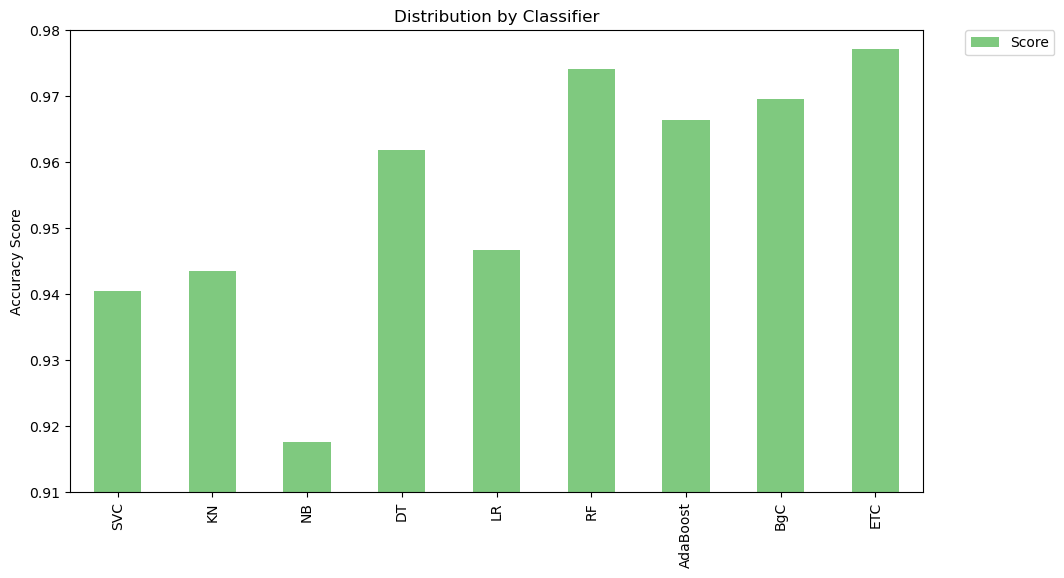

In [161]:
res.plot(kind='bar', ylim=(0.91,0.98), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), res.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Обучим персептрон

In [145]:
#настроим персептрон
mlp_model = Sequential()
mlp_model.add(Dense(512, input_shape=(x_train.shape[1],)))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(2))
mlp_model.add(Activation('softmax'))

mlp_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print(mlp_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               8192      
                                                                 
 activation_28 (Activation)  (None, 512)               0         
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 2)                 1026      
                                                                 
 activation_29 (Activation)  (None, 2)                 0         
                                                                 
Total params: 9,218
Trainable params: 9,218
Non-trainable params: 0
_________________________________________________________________
None


In [146]:
#обучаем модель
mlp_history = mlp_model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
185/185 [==============================] - 1s 1ms/step - loss: 0.4238 - acc: 0.8926 - val_loss: 0.2438 - val_acc: 0.9146
Epoch 2/50
185/185 [==============================] - 0s 930us/step - loss: 0.2575 - acc: 0.9371 - val_loss: 0.1777 - val_acc: 0.9390
Epoch 3/50
185/185 [==============================] - 0s 941us/step - loss: 0.2040 - acc: 0.9395 - val_loss: 0.1613 - val_acc: 0.9360
Epoch 4/50
185/185 [==============================] - 0s 903us/step - loss: 0.1683 - acc: 0.9454 - val_loss: 0.1655 - val_acc: 0.9497
Epoch 5/50
185/185 [==============================] - 0s 914us/step - loss: 0.1500 - acc: 0.9549 - val_loss: 0.1144 - val_acc: 0.9558
Epoch 6/50
185/185 [==============================] - 0s 903us/step - loss: 0.1424 - acc: 0.9507 - val_loss: 0.1510 - val_acc: 0.9390
Epoch 7/50
185/185 [==============================] - 0s 947us/step - loss: 0.1309 - acc: 0.9539 - val_loss: 0.1061 - val_acc: 0.9634
Epoch 8/50
185/185 [==============================] - 0s 914us/s

In [120]:
#сохраняем обученную модель
joblib.dump(mlp_model, './Models/MLP.pkl')

['./Models/MLP.pkl']

✔️Можем теперь пропустить этап обучения персептрона и загрузить его из файла

In [121]:
#загрузим из файла обученную модель
mlp_model=joblib.load('./Models/MLP.pkl')

In [147]:
# валидируем
score = mlp_model.evaluate(x_test, y_test, batch_size=32, verbose=1)
print(u'loss: {}'.format(score[0]))
print(u'accuracy: {}'.format(score[1]))

21/21 [==============================] - 0s 701us/step - loss: 0.0813 - acc: 0.9741
loss: 0.08132943511009216
accuracy: 0.9740853905677795


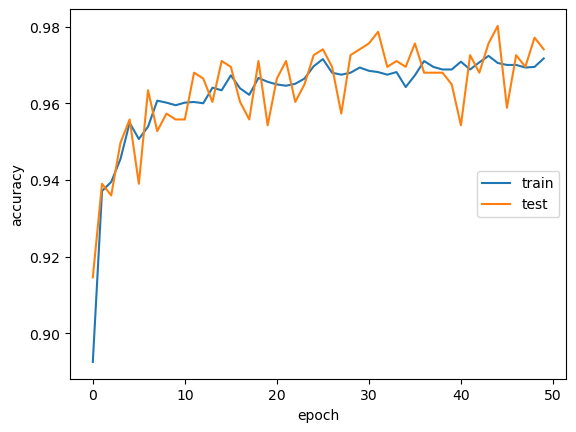

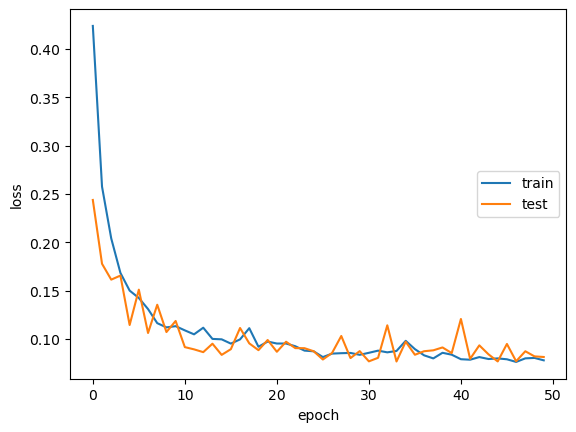

In [148]:
#график точности модели
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()
#график потерь модели
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

## Тестирование

Попробуем протестировать модели на дополнительных датасетах

In [95]:
#загружаем три дополнительных датасета
bonus_phishing_emails = [mailbox.mbox('./Datasets/phishing0.mbox'), 
                        mailbox.mbox('./Datasets/phishing1.mbox'), 
                        mailbox.mbox('./Datasets/phishing2.mbox')]

df3 = pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId', 'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId', 'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId', 'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls', 'noOfSpecialCharsInUrls', 'hasIpAddressInUrls', 'noOfIpAddressInUrls', 'noOfHttpLinks','no_of_attachments','class_label'])
stringUtil = StringUtil()
for emails in bonus_phishing_emails:
    for email in emails:
        #парсим каждое фишинговое письмо
        emailParser = EmailParser(email)
        #определяем количество вложений
        no_of_attachments = emailParser.get_no_of_attachments()
        #определяем признаки почты отправителя
        emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
        #определяем признаки ссылок
        urls_features = stringUtil.process_urls(emailParser.get_urls())
        #выделяем количество слов стемминга
        word_dict = stringUtil.process_text(emailParser.get_email_text())
        #заполняем датафрейм
        df3.loc[len(df3)] = [word_dict, emailid_features[0], emailid_features[1], emailid_features[2], emailid_features[3], emailid_features[4], emailid_features[5], urls_features[0],urls_features[1],urls_features[2],urls_features[3],urls_features[4],urls_features[5], urls_features[6], no_of_attachments, 1]

#определяем самые часто встречаемые слова из фишинговых сообщений
malicious_words = stringUtil.get_most_common_words()

#заменим признак "текст" на признак "самые часто встречаемые слова из фишинговых сообщений"
df3['noOfMaliciousWords'] = df3['text'].apply(lambda x: len(set(x.keys()).intersection(set(dict(malicious_words).keys()))))
df3 = df3.drop(columns=['text'])

df3.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpLinks,no_of_attachments,class_label,noOfMaliciousWords
0,19,0,1,0,0,0,7,24,5,8,1,1,7,0,1,79
1,20,0,1,0,0,0,14,41,9,16,0,0,14,0,1,127
2,20,0,0,0,1,1,71,305,2,94,0,0,71,0,1,102
3,25,0,1,0,0,0,1,4,0,2,1,1,1,0,1,30
4,19,0,1,0,0,0,18,55,4,59,0,0,18,0,1,63


In [96]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            2293 non-null   int64
 1   noOfDotsInEmailId          2293 non-null   int64
 2   noOfDashesInEmailId        2293 non-null   int64
 3   noOfSpecialCharsInEmailId  2293 non-null   int64
 4   noOfDigitsInEmailId        2293 non-null   int64
 5   noOfSubdomainsInEmailId    2293 non-null   int64
 6   noOfUrls                   2293 non-null   int64
 7   noOfDotsInUrls             2293 non-null   int64
 8   noOfDashesInUrls           2293 non-null   int64
 9   noOfSpecialCharsInUrls     2293 non-null   int64
 10  hasIpAddressInUrls         2293 non-null   int64
 11  noOfIpAddressInUrls        2293 non-null   int64
 12  noOfHttpLinks              2293 non-null   int64
 13  no_of_attachments          2293 non-null   int64
 14  class_label             

Оптимизируем типы данных

In [97]:
df3 = df3.astype('int16')
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            2293 non-null   int16
 1   noOfDotsInEmailId          2293 non-null   int16
 2   noOfDashesInEmailId        2293 non-null   int16
 3   noOfSpecialCharsInEmailId  2293 non-null   int16
 4   noOfDigitsInEmailId        2293 non-null   int16
 5   noOfSubdomainsInEmailId    2293 non-null   int16
 6   noOfUrls                   2293 non-null   int16
 7   noOfDotsInUrls             2293 non-null   int16
 8   noOfDashesInUrls           2293 non-null   int16
 9   noOfSpecialCharsInUrls     2293 non-null   int16
 10  hasIpAddressInUrls         2293 non-null   int16
 11  noOfIpAddressInUrls        2293 non-null   int16
 12  noOfHttpLinks              2293 non-null   int16
 13  no_of_attachments          2293 non-null   int16
 14  class_label             

Сохраним обработанный тестовый набор

In [98]:
df3.to_csv("./Data/data_test.csv", sep=',')

Загружаем датасет с файла

In [149]:
df3 = pd.read_csv("./Data/data_test.csv").drop('Unnamed: 0', axis=1)
df3.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpLinks,no_of_attachments,class_label,noOfMaliciousWords
0,19,0,1,0,0,0,7,24,5,8,1,1,7,0,1,79
1,20,0,1,0,0,0,14,41,9,16,0,0,14,0,1,127
2,20,0,0,0,1,1,71,305,2,94,0,0,71,0,1,102
3,25,0,1,0,0,0,1,4,0,2,1,1,1,0,1,30
4,19,0,1,0,0,0,18,55,4,59,0,0,18,0,1,63


In [100]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   lengthOfEmailId            2293 non-null   int64
 1   noOfDotsInEmailId          2293 non-null   int64
 2   noOfDashesInEmailId        2293 non-null   int64
 3   noOfSpecialCharsInEmailId  2293 non-null   int64
 4   noOfDigitsInEmailId        2293 non-null   int64
 5   noOfSubdomainsInEmailId    2293 non-null   int64
 6   noOfUrls                   2293 non-null   int64
 7   noOfDotsInUrls             2293 non-null   int64
 8   noOfDashesInUrls           2293 non-null   int64
 9   noOfSpecialCharsInUrls     2293 non-null   int64
 10  hasIpAddressInUrls         2293 non-null   int64
 11  noOfIpAddressInUrls        2293 non-null   int64
 12  noOfHttpLinks              2293 non-null   int64
 13  no_of_attachments          2293 non-null   int64
 14  class_label             

In [150]:
pred_dict={}
# пробежимся по классификаторам
for k,v in clfs.items():
    # классифицируем тестовые выборки
    pred = predict_labels(v,np.array(df3.drop(columns='class_label')))
    # записываем точность классификатора
    pred_dict[k]=[accuracy_score(np.array(df3['class_label']),pred)]

#персептрон
mlp_score = mlp_model.evaluate(np.array(df3.drop(columns='class_label')), np.array(df3['class_label']), batch_size=8, verbose=1)    
pred_dict['MLP']=[mlp_score[1],]

# объявляем датафрейм на основе собранной статистики по классификаторам
res = pd.DataFrame.from_dict(pred_dict, orient='index', columns=['Score'])

res

287/287 [==============================] - 0s 605us/step - loss: 0.3403 - acc: 0.8997


,Score
SVC,0.808984
KN,0.825120
NB,0.785434
DT,0.886611
LR,0.834278
RF,0.930659
AdaBoost,0.907981
BgC,0.915395
ETC,0.934147
MLP,0.899695


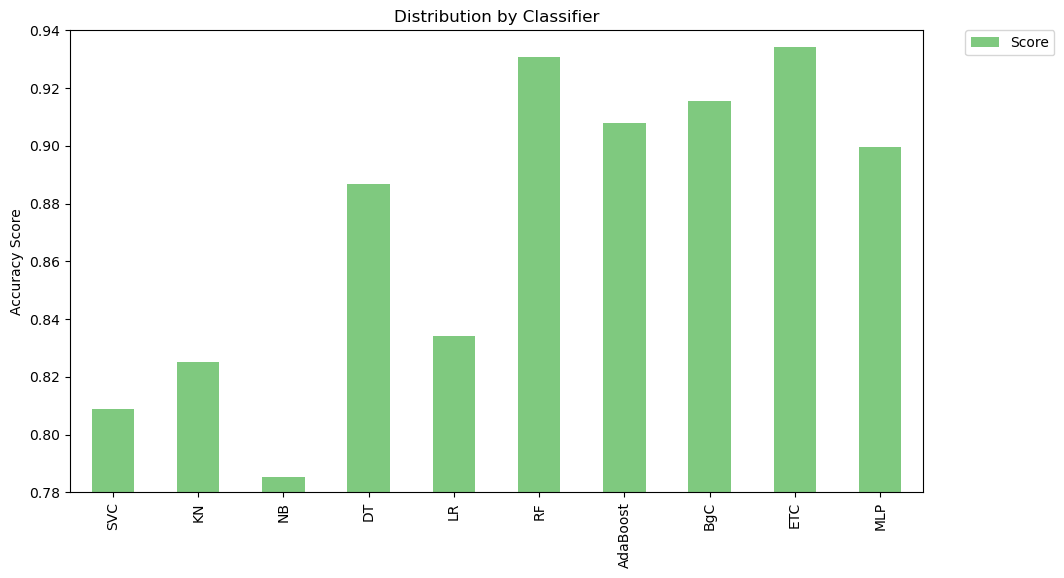

In [151]:
#визуализируем
res.plot(kind='bar', ylim=(0.78,0.94), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(res.shape[0]), res.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

По полученным результатам можем выделить алгоритм Extra Trees как победителя в номинации лучший классификатор фишинговых сообщений (с учётом обучающих данных и выделенных признаков).

# Оптимизация гиперпараметров модели ETC

Есть несколько способов определить, какие гиперпараметры следуюет насторить для нашей модели. Хороший способ визуально оценить потенциальные оптимизированные значения гиперпараметров модели — использовать кривую проверки. Кривая проверки может быть построена на графике, чтобы показать, насколько хорошо модель работает с различными значениями одного гиперпараметра.

Воссоздадим набор данных для обучения

In [163]:
df = pd.read_csv("./Data/data.csv").drop('Unnamed: 0', axis=1)
x = df.drop(columns=["class_label"]).values
y = df["class_label"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=34, test_size=0.1)

Посчитаем оптимальный параметр n_estimators

In [164]:
num_est = np.arange(10, 210, 10)
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                ExtraTreesClassifier(), 
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)

Отобразим на графике

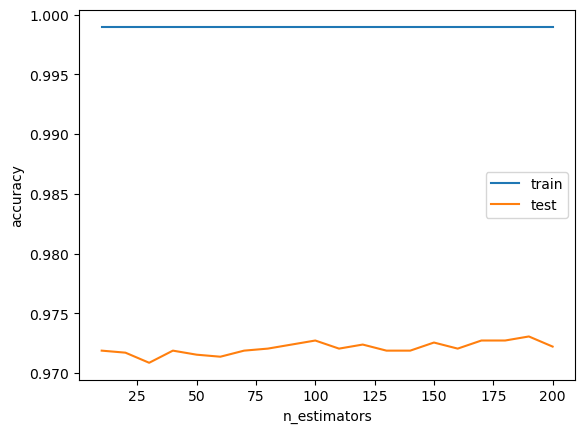

In [165]:
plt.plot(num_est, np.mean(train_scoreNum, axis = 1))
plt.plot(num_est, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Пиковое значение точности можем видеть при n_estimators в районе 190. Уточним значение

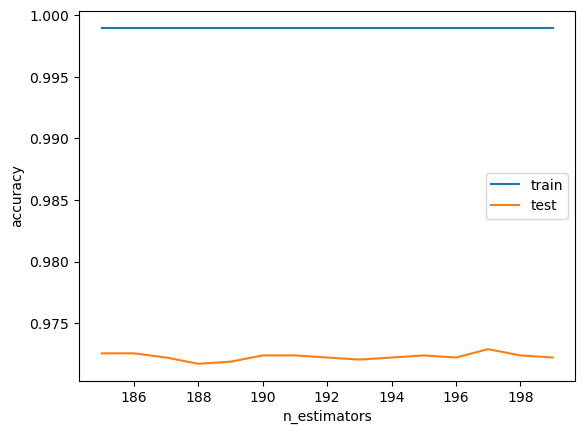

In [166]:
num_est = np.arange(185, 200, 1)
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                ExtraTreesClassifier(), 
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)
plt.plot(num_est, np.mean(train_scoreNum, axis = 1))
plt.plot(num_est, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Теперь явно видно, что пиковое значение точности достигается при **n_estimators = 197**. Зафиксируем данное значение.

Далее попробуем оценить оптимальное значение гиперпараметра max_depth

In [168]:
num_md = np.arange(10, 110, 10)
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                ExtraTreesClassifier(n_estimators=197), 
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = num_md, cv = 3)

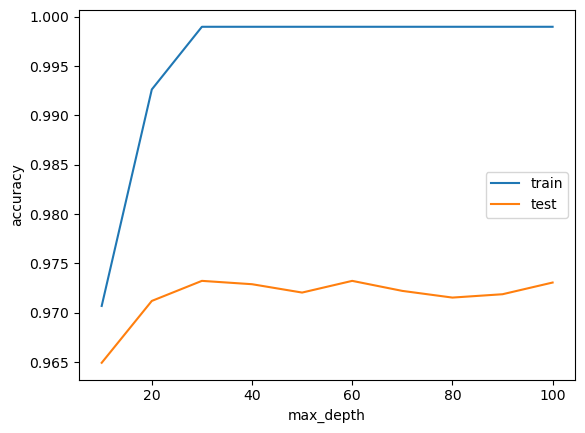

In [169]:
plt.plot(num_md, np.mean(train_scoreNum, axis = 1))
plt.plot(num_md, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'test'], loc='center right')
plt.show()

На данном графике оптимальное значение гиперпараметра max_depth наблюдается в районе 60. Уточним значение

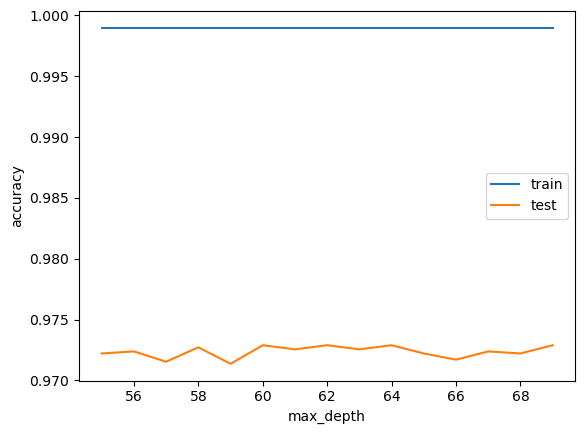

In [170]:
num_md = np.arange(55, 70, 1)
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                ExtraTreesClassifier(n_estimators=197), 
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = num_md, cv = 3)

plt.plot(num_md, np.mean(train_scoreNum, axis = 1))
plt.plot(num_md, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Остановимся на значении **max_depth = 60**

Посмотрим оптимальное значение гиперпараметра bootstrap

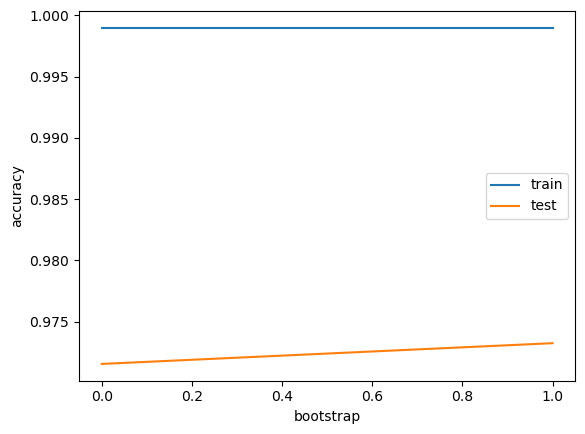

In [171]:
num_bs = np.array([False, True])
train_scoreNum, test_scoreNum = model_selection.validation_curve( 
                                ExtraTreesClassifier(n_estimators=197, max_depth=60), 
                                X = x_train, y = y_train, 
                                param_name = 'bootstrap', 
                                param_range = num_bs, cv = 3)

plt.plot(num_bs, np.mean(train_scoreNum, axis = 1))
plt.plot(num_bs, np.mean(test_scoreNum, axis = 1))
plt.ylabel('accuracy')
plt.xlabel('bootstrap')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Значение точности выше при настройке **bootstrap = True**

Попробуем обучить модель с полученными значениями гиперпараметров и оценим результат

In [172]:
et = ExtraTreesClassifier(n_estimators=197, max_depth=60, bootstrap=True, random_state=111)
et.fit(x_train, y_train)
et_pred = et.predict(x_test)
accuracy_score(y_test,et_pred)

0.975609756097561

Сравним полученное значение точности с точностью базовой модели

In [173]:
etc = joblib.load('./Models/ETC.pkl')
etc_pred = etc.predict(x_test)
accuracy_score(y_test,etc_pred)

0.9771341463414634

В результате ручного подбора гиперпараметров, можем наблюдать снижение точности модели

In [174]:
df3 = pd.read_csv("./Data/data_test.csv").drop('Unnamed: 0', axis=1)
# классифицируем тестовые выборки
et_pred = et.predict(np.array(df3.drop(columns='class_label')))
etc_pred = etc.predict(np.array(df3.drop(columns='class_label')))
# запишем точность моделей
print('et acc:', accuracy_score(np.array(df3['class_label']),et_pred))
print('etc acc:', accuracy_score(np.array(df3['class_label']),etc_pred))

et acc: 0.9345835150457915
etc acc: 0.9341474051460968


Теперь сравним результаты значения точности модели Extra Trees в базовой настройке и при явном указании параметров. Для базового набора данных получаем значения 97,56% и 97,71% в пользу базовой настройки. Для дополнительных наборов получаем значения 93,45% и 93,41% в пользу уже настроенной вручную модели (даже при условии, что мы выставляли параметры на базе основного набора).

## Результаты

Результатом проекта является определенность в том, что при используемых наборах данных, выделяемых признаках и настройках моделей оптимальным классификатором выступает модель Extra Trees. При этом базовая модель самостоятельно подбирает близкие к оптимальным гиперпараметры для модели. Несмотря на это явное указание гиперпараметров для повышения точности классификатора может дать небольшое преимущество.

Существует вероятность, что при использовании других моделей может быть полезна явная настройка гиперпараметров, которая покажет гораздо более высокие результаты относительно базовой модели. В случае с моделью Extra Trees в этом может не быть необходимости, так как данная модель по умолчанию выставляет оптимальные параметры. Процесс подбора значений гиперпараметров может занять очень много времени и не дать положительных результатов, но не исключается вероятность существования случаев, где данное решение будет вполне оправдано.

# Заключение

Таким образом, в ходе работы над проектом, по полученным результатам видно, что модель Extra Trees – лучший алгоритм для обнаружения фишинговых сообщений с учетом обучающего набора и выделяемых признаков. Точность 1 предполагает, что каждое нефишинговое письмо будет корректно идентифицировано и не попадет в папку со спамом, если это будет реализовано в реальном решении.

Алгоритм Extra Trees показал наивысший, среди других моделей, результат приблизительно равный 0,98. Соответственно, существует вероятность того, что небольшая часть фишинговых сообщений всё же попадет в почтовый ящик незамеченной. В случае со случайным лесом – около 2 из 100 фишинговых писем останутся незамеченными. При дополнительной проверке данный алгоритм всё также показал наивысшую точность классификации приблизительно равную 0,935. На данном наборе около 6-7 из 100 фишинговых писем остались незамеченными.

Необходимость предобработки данных и выделения признаков для классификации может влиять на производительность.
Стоит отметить, что нам удалось достичь лучших показателей точности выбранного классификатора для дополнительных наборов фишинговых сообщений путем подбора и явного указания гиперпараметров.
Учитывая тенденции использования фишингового подхода среди злоумышленников, ожидаются все более изощренные способы обмана пользователей. Поэтому необходимо постоянно пополнять хранилище детектированных фишинговых сообщения с целью повышения качества классификации данного типа угроз информационной безопасности.

# Список используемых источников

1. Спам и фишинг в 2022 году // https://securelist.ru/ : сайт. - URL: https://securelist.ru/spam-phishing-scam-report-2022/106719/ (дата обращения: 20.03.2023);
1. Лаборатория Касперского" заблокировала 800 тыс. русских фишинговых писем в 2022 году // https://tass.ru/ : сайт. - URL: https://tass.ru/obschestvo/14635485 (дата обращения: 20.03.2023);
1. Как угнать данные за 15 минут // https://habr.com/ : сайт. - URL: https://habr.com/ru/companies/pt/articles/728170/ (дата обращения: 20.04.2023);
1. Enron Dataset // https://www.cs.cmu.edu/ : сайт. - URL: https://www.cs.cmu.edu/~enron/ (дата обращения: 20.03.2023);
1. Nazario Datasets // https://www.monkey.org/ : сайт. - URL: https://www.monkey.org/~jose/phishing/ (дата обращения: 20.03.2023);
1. Искусственный интеллект: технологии и применение // https://rdc.grfc.ru/ : сайт. - URL: https://rdc.grfc.ru/2020/12/aitech/ (дата обращения: 20.03.2023);
1. Фишинговые письма // https://phishman.ru/ : сайт. - URL: https://phishman.ru/blog/phishing-emails (дата обращения: 20.03.2023);
1. Не дайте себя обмануть - 7 признаков фишинговых писем // https://vc.ru : сайт. - URL: https://vc.ru/services/119070-ne-dayte-sebya-obmanut-7-priznakov-fishingovyh-pisem (дата обращения: 20.03.2023);
1. Keras и Tensorflow - классификация текста // https://cloud.croc.ru/ : сайт. - URL: https://cloud.croc.ru/blog/about-technologies/keras-i-tensorflow-klassifikatsiya-teksta/ (дата обращения: 20.03.2023).
